# Анализ бизнес-показателей

## Описание проекта

**Цели и задачи**

Цель проекта - разобраться в причинах убыточности рекламной компании развлекательного приложения Procrastinate Pro+ и помочь компании выйти в плюс.

Задачи для исследования:

* выяснить откуда приходят пользователи и какими устройствами они пользуются,
* выяснить сколько стоит привлечение пользователей из различных рекламных каналов;
* выяснить сколько денег приносит каждый клиент,
* выяснить когда расходы на привлечение клиента окупаются,
* выяснить какие факторы мешают привлечению клиентов.


**Описание данных**

Имеются данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года.

Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, `orders_info_short.csv` — информацию о заказах, а `costs_info_short.csv` — информацию о расходах на рекламу.

Структура `visits_info_short.csv`:
* `User Id` — уникальный идентификатор пользователя,
* `Region` — страна пользователя,
* `Device` — тип устройства пользователя,
* `Channel` — идентификатор источника перехода,
* `Session Start` — дата и время начала сессии,
* `Session End` — дата и время окончания сессии.

Структура `orders_info_short.csv`:
* `User Id` — уникальный идентификатор пользователя,
* `Event Dt` — дата и время покупки,
* `Revenue` — сумма заказа.

Структура `costs_info_short.csv`:
* `dt` — дата проведения рекламной кампании,
* `Channel` — идентификатор рекламного источника,
* `costs` — расходы на эту кампанию.

## Загрузка данных и подготовка к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
try:    
    visits , orders , costs = (
        pd.read_csv('metrics_data/visits_info_short.csv'),
        pd.read_csv('metrics_data/orders_info_short.csv'),
        pd.read_csv('metrics_data/costs_info_short.csv')  
) 

except:
    visits , orders , costs = (
        pd.read_csv('/datasets/visits_info_short.csv'),
        pd.read_csv('/datasets/orders_info_short.csv'),
        pd.read_csv('/datasets/costs_info_short.csv')    
)

In [6]:
display(visits.head(1)) , display(orders.head(1)) , display(costs.head(1))

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3


(None, None, None)

In [143]:
visits.info() , orders.info() , costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   

(None, None, None)

Первое знакомство с данными показало, что пропущенных значений нет.

В качестве предобработки необходимо сделать следующее:
* название колонок в датафреймах привести к змеиному регистру - убрать пробелы и заменить заглавные буквы на строчные
* сменить формат столбцов `Session Start` , `Session End` , `Event Dt` , `dt` на `datetime`
* проверить значения на явные и неявные дубликаты

In [144]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns]
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns]


visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [145]:
# проверяем на дубликаты
visits.duplicated().sum() , orders.duplicated().sum() , costs.duplicated().sum()

(0, 0, 0)

In [146]:
# посмотрим уникальные значения в столбцах
visits.region.unique() , visits.device.unique(), visits.channel.sort_values().unique()

(array(['United States', 'UK', 'France', 'Germany'], dtype=object),
 array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object),
 array(['AdNonSense', 'FaceBoom', 'LeapBob', 'MediaTornado',
        'OppleCreativeMedia', 'RocketSuperAds', 'TipTop', 'WahooNetBanner',
        'YRabbit', 'lambdaMediaAds', 'organic'], dtype=object))

In [147]:
costs.channel.sort_values().unique()

array(['AdNonSense', 'FaceBoom', 'LeapBob', 'MediaTornado',
       'OppleCreativeMedia', 'RocketSuperAds', 'TipTop', 'WahooNetBanner',
       'YRabbit', 'lambdaMediaAds'], dtype=object)

## Функции для расчёта LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

### Профили пользователей

In [148]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs): #, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


### Удержание

In [149]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Конверсия

In [150]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### LTV и ROI

In [151]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days = horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Сглаживание и график удержания

In [152]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [153]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### График конверсии

In [154]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### График LTV и ROI

In [155]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

В ходе исследовательского анализа данных:

- Составляем профили пользователей. Определяем минимальную и максимальную даты привлечения пользователей.
- Выясняем, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Строим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Выясняем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Строим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучаем рекламные источники привлечения и определяем каналы, из которых пришло больше всего платящих пользователей. Строим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

### Профили

In [156]:
profiles = get_profiles(visits, orders, costs)
profiles.head(2)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237


In [157]:
# найдем минимальную дату привлечения
first_user = profiles.sort_values(by = 'dt').head(1)
first_user['dt'].reset_index()

,index,dt
0,110838,2019-05-01


In [158]:
# найдем максимальную дату привлечения
last_user = profiles.sort_values(by = 'dt').tail(1)
last_user['dt'].reset_index()

,index,dt
0,38973,2019-10-27


Самый первый пользватель был привлечен 01.05.2019, а самый последний - 27.10.2019, что соответствует информации указанной во введении.

### Страны

In [159]:
# Страны пользователей
user_regions = pd.DataFrame({'regions':list(profiles.region.unique())})
user_regions

,regions
0,United States
1,France
2,Germany
3,UK


Для того чтобы определить из каких регионов приходит больше всего *платящих* пользователей, построю график

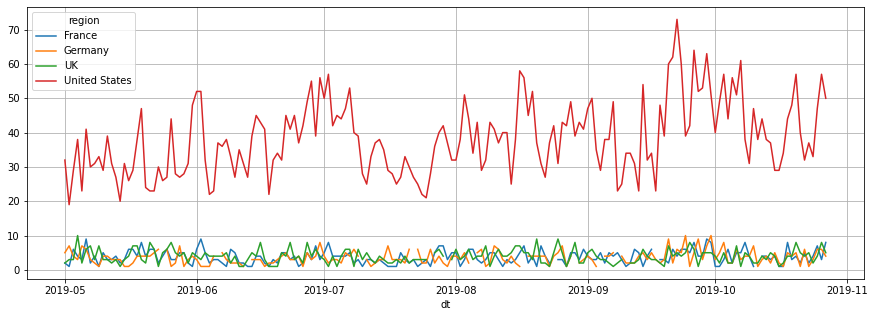

In [160]:
profiles.query('payer == True').pivot_table(
    index='dt',  # даты первых посещений
    columns='region',  # регион переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)

plt.show()

В США больше всего платящих пользователей.

*Строим таблицу, отражающую количество пользователей и долю платящих из каждой страны.*

In [161]:
profiles.groupby('region').agg({'user_id' : 'nunique' , 'payer' : 'mean'}).round(3)

,user_id,payer
region,,
France,17450,0.038
Germany,14981,0.041
UK,17575,0.040
United States,100002,0.069


Самая большая доля платящих пользователей из США - 6.9%, среди остальных стран доли приблизительно одинаковые: 3.8-4.1%.

Также, в США ~ в 6 раз больше общее количество пользователей, чем в других странах.

### Устройства

*Выясним, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.*

In [162]:
# Устройства пользователей
user_device = pd.DataFrame({'device':list(profiles.device.unique())})
user_device

,device
0,Mac
1,iPhone
2,PC
3,Android


In [163]:
(
    profiles.groupby("device")
    .agg({"user_id": "nunique", "payer": "mean"})
    .round(3)
    .sort_values(by="payer", ascending=False)
)


,user_id,payer
device,,
Mac,30042,0.064
iPhone,54479,0.062
Android,35032,0.059
PC,30455,0.050


Большая часть платящих пользователей предпочитает Mac - 6.4%.

Меньше всего платящих среди пользователей PC - 5.0%

### Рекламные каналы

*Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.*

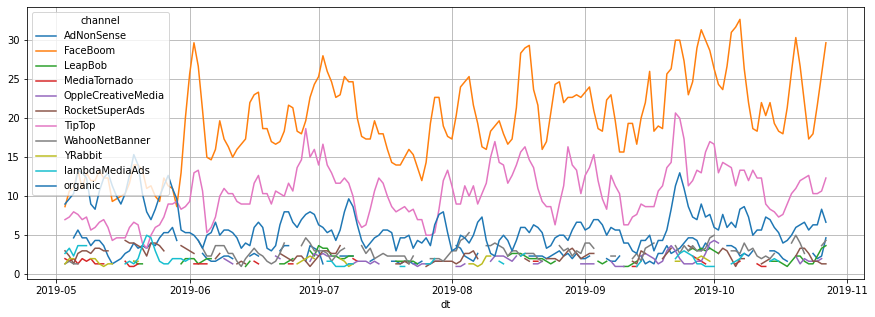

In [164]:
payers_from_channels = profiles.query('payer == True').pivot_table(
    index='dt',  # даты первых посещений
    columns='channel',  # регион переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
)

filter_data(payers_from_channels, 3)
payers_from_channels.plot(figsize=(15, 5), grid=True)

plt.show()

В тройке лидеров по привлечению платящих пользователей оказались каналы - `FaceBoom` , `TipTop` , `AdNonSense`

In [165]:
(
    profiles.groupby("channel")
    .agg({"user_id": "nunique", "payer": "mean"})
    .round(3)
    .sort_values(by="payer", ascending=False)
)

,user_id,payer
channel,,
FaceBoom,29144,0.122
AdNonSense,3880,0.113
lambdaMediaAds,2149,0.105
TipTop,19561,0.096
RocketSuperAds,4448,0.079
WahooNetBanner,8553,0.053
YRabbit,4312,0.038
MediaTornado,4364,0.036
LeapBob,8553,0.031


При оценке доли платящих пользователей для каждого канала, картина следующая - на первом месте также `FaceBoom` , второе и третье место у `AdNonSense` и `lambdaMediaAds`.

Органических пользователей больше всего, но среди них меньше всего платящих пользователей.

## Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

### Общая сумма расходов на маркетинг

In [167]:
costs_sum = costs.costs.sum()
costs_sum.round()

105497.0

### Траты по источникам

*Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.*

In [168]:
channel_costs = costs.groupby('channel').agg({'costs' : 'sum'})
channel_costs.sort_values(by = 'costs' , ascending = False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


In [169]:
# посмотрим на затраты на рекламу в процентных соотношениях
pipi = []
for t in channel_costs["costs"]:
    pipi.append(t / channel_costs["costs"].sum() * 100)
channel_costs["rate"] = pipi
channel_costs.sort_values(by="costs", ascending=False).T.round(2)

channel,TipTop,FaceBoom,WahooNetBanner,AdNonSense,OppleCreativeMedia,RocketSuperAds,LeapBob,lambdaMediaAds,MediaTornado,YRabbit
costs,54751.3,32445.60,5151.00,3911.25,2151.25,1833.00,1797.6,1557.60,954.48,944.22
rate,51.9,30.75,4.88,3.71,2.04,1.74,1.7,1.48,0.90,0.90


Больше всего денег (более 80% бюджета) было вложено в каналы `TipTop` и `FaceBoom` - как выяснили ранее, эти каналы также привлекли больше всего платящих клиентов. 

### Изменение расходов во времени

Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

In [170]:
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month

costs.head(1)

,dt,channel,costs,week,month
0,2019-05-01,FaceBoom,113.3,18,5


In [171]:
weekly_costs = costs.pivot_table(
    index="week", columns="channel", values="costs", aggfunc="sum"
)
weekly_costs.head(1)

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
week,,,,,,,,,,
18,211.05,535.7,16.8,38.64,24.0,99.45,347.0,49.2,52.2,81.6


In [172]:
monthly_costs = costs.pivot_table(
    index="month", columns="channel", values="costs", aggfunc="sum"
)
monthly_costs.head(1)

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
month,,,,,,,,,,
5,1169.7,3524.4,140.28,238.56,169.75,577.98,2981.0,418.8,299.7,458.4


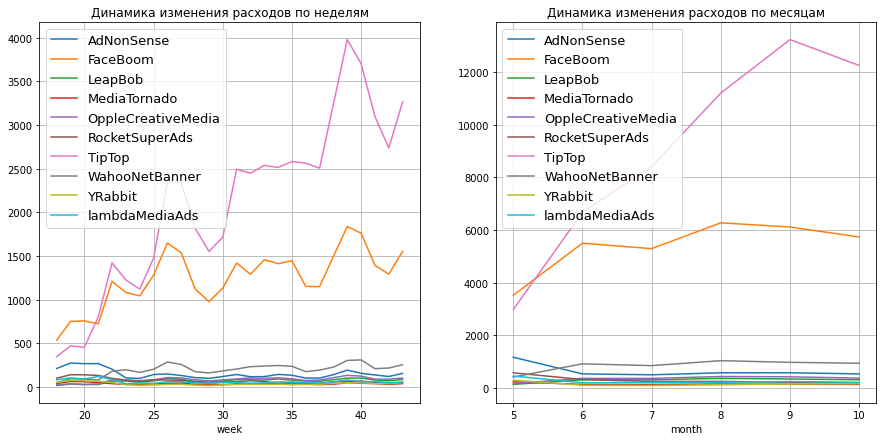

In [173]:
plt.figure(figsize=(15, 7))

weekly_costs.plot(grid=True,  ax=plt.subplot(1, 2, 1))
plt.legend(fontsize = 13 , loc = 2)
plt.title('Динамика изменения расходов по неделям')

monthly_costs.plot(grid=True,  ax=plt.subplot(1, 2, 2))
plt.legend(fontsize = 13 , loc = 2)
plt.title('Динамика изменения расходов по месяцам')
plt.show()

In [174]:
monthly_costs.drop(columns = ['FaceBoom' , 'TipTop'])

channel,AdNonSense,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,WahooNetBanner,YRabbit,lambdaMediaAds
month,,,,,,,,
5,1169.70,140.28,238.56,169.75,577.980,418.8,299.70,458.4
6,538.65,314.58,138.00,370.00,325.715,921.0,106.20,199.2
7,504.00,313.53,138.48,366.50,252.070,851.4,97.38,219.2
8,579.60,369.81,154.56,439.25,253.110,1040.4,124.74,220.0
9,581.70,343.98,144.72,427.75,218.400,977.4,152.79,247.2
10,537.60,315.42,140.16,378.00,205.725,942.0,163.41,213.6


График показывает, что в каналы `TipTop` и `FaceBoom` вкладывались деньги на протяжении всего рассматриваемого периода, постоянно увеличивая расходы.

Расходы на остальные каналы на протяжение всего времени были относительно одинаковы и постоянны.

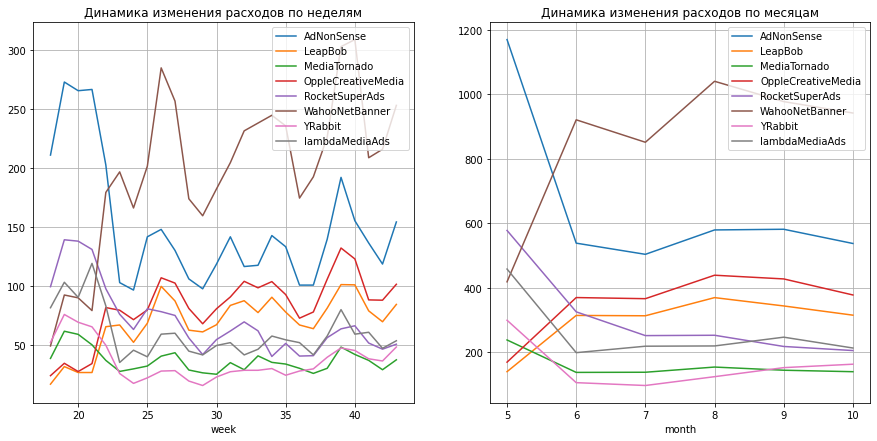

In [175]:
plt.figure(figsize=(15, 7))

weekly_costs.drop(columns = ['FaceBoom' , 'TipTop'])\
.plot(grid=True,  ax=plt.subplot(1, 2, 1))
plt.legend(fontsize = 10 , loc = 1)
plt.title('Динамика изменения расходов по неделям')

monthly_costs.drop(columns = ['FaceBoom' , 'TipTop'])\
.plot(grid=True,  ax=plt.subplot(1, 2, 2))
plt.legend(fontsize = 10 , loc = 1)
plt.title('Динамика изменения расходов по месяцам')
plt.show()

В группе низкобюджетных каналов можно увидеть повышенное финансирование в первый месяц рекламной кампании с дальнейшим понижением ~ в 2 раза для каналов `AdNonSense` , `RocketSuperAds`, `lambdaMediaAds`, `MediaTornado` и `YRabbit`. И наоборот, боджет постепенно увеличивается для каналов `WahooNetBanner`, `OppleCreativeMedia` и `LeapBob`. 

### Привлечение одного юзера из каждого источника

*Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.*

In [176]:
profiles.head(2)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237


In [177]:
cac_mean = profiles.groupby('channel').agg({'acquisition_cost' : 'mean'}).round(3)
cac_mean.sort_values(by = 'acquisition_cost', ascending = False)

,acquisition_cost
channel,
TipTop,2.799
FaceBoom,1.113
AdNonSense,1.008
lambdaMediaAds,0.725
WahooNetBanner,0.602
RocketSuperAds,0.412
OppleCreativeMedia,0.250
MediaTornado,0.219
YRabbit,0.219


Самыми "дорогими" пользователями являются ползьватели привлеченные каналами `TipTop`, `FaceBoom` и `AdNonSense`. При чем затраты на одного полльзователя `TipTop` почти в 2.5 раза больше, чем на пользователя следующего за ним канала `FaceBoom`.

## Окупаемость рекламы

Проанализируем окупаемость рекламы.   
Согласно ТЗ, расчет ведется от 1 ноября 2019 года и пользователи должны окупаться не позднее чем через две недели после привлечения.

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию и удержание пользователей и динамику их изменений.
- Проанализируем окупаемость рекламы со следующими разбивками:
    - по устройствам,
    - по странам,
    - по рекламным каналам.

In [178]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

### Общая окупаемость 

*Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.*

In [179]:
# убираем органический трафик для последующего анализа
visits = visits.query('channel != "organic"')
costs = costs.query('channel != "organic"')
profiles = profiles.query('channel != "organic"')

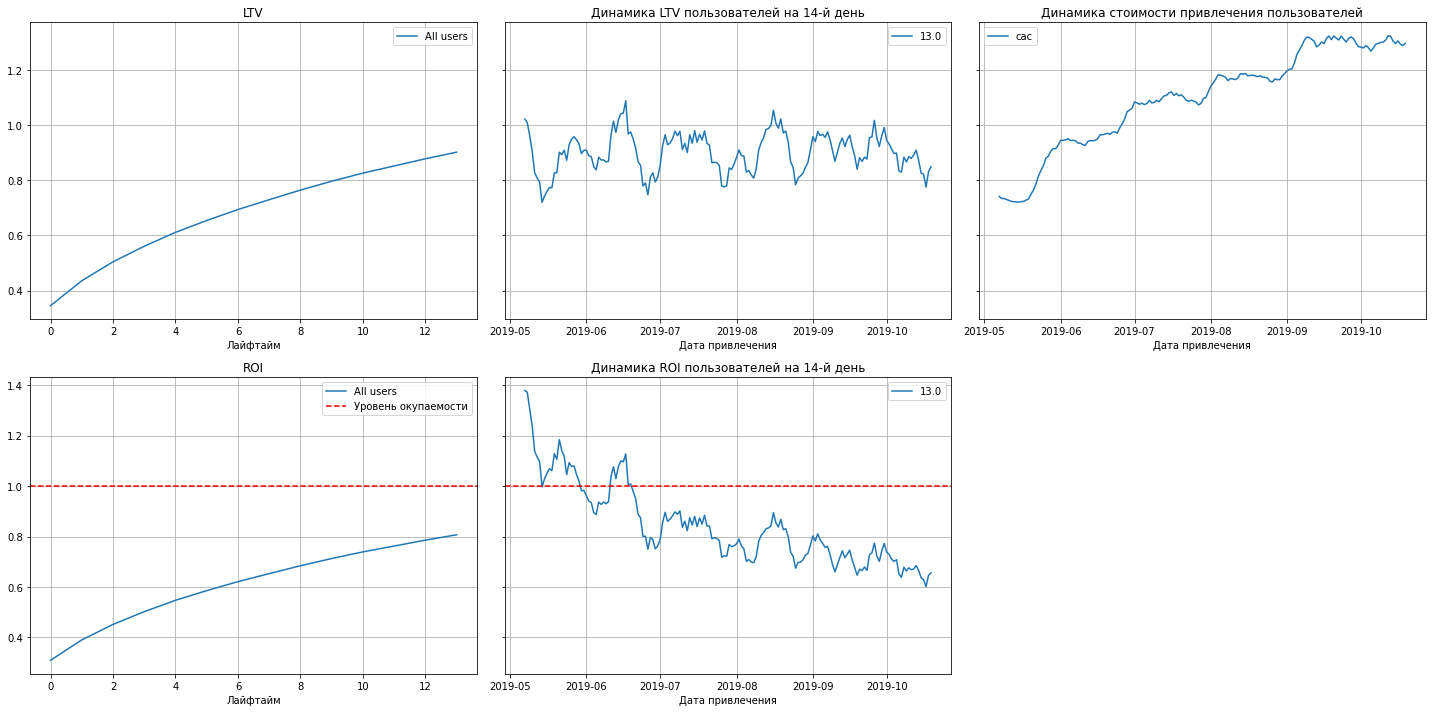

In [180]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

* Динамика LTV достаточно стабильная - значения достигают пиков в середине месяца и понижаются к началу месяца.

* Стоимость привлечения резко возрастает на втором месяце и дальше только продолжает расти.

* ROI в конце второй недели ниже уровня окупаемости. Если смотреть на динамику изменения ROI, можно заметить, что в первый же месяц ROI спускается до порога окупаемости и начиная с середины июня уже не поднимается выше порога окупаемости.
* Можно сделать вывод, что реклама не окупается.

Ранее было определено, что только в два канала с течением времени вкладывается все больше средств по сравнению с остальными - `TipTop` и `FaceBoom`. При чем затраты на одного полльзователя `TipTop` почти в 2.5 раза больше, чем на пользователя следующего за ним канала `FaceBoom`.

Вероятно, стоило бы снизить расходы на рекламу в `TipTop` и обратить внимание на другие источники, поскольку данный канал исчерпал свой ресурс.

### Конверсия и удержание

*Проверим конверсию и удержание пользователей и динамику их изменений.*

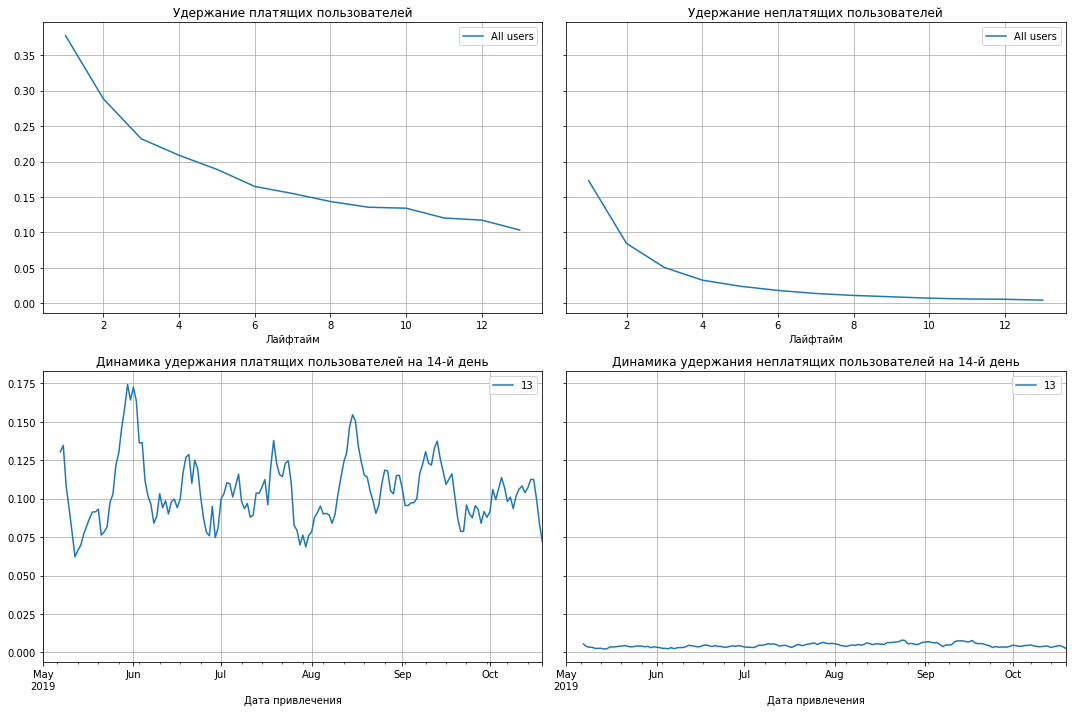

In [181]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

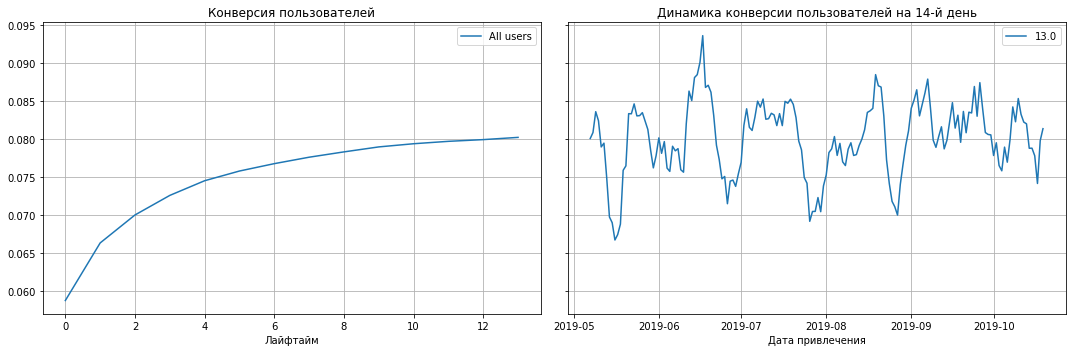

In [182]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

В графиках удержания и конверсии без разбивок ничего подозрительного нет - удержание стабильное, конверсия резко растет в начале второго месяца, достигая значения в 8% к конце второй недели.

### Окупаемость по устройствам

*Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.*

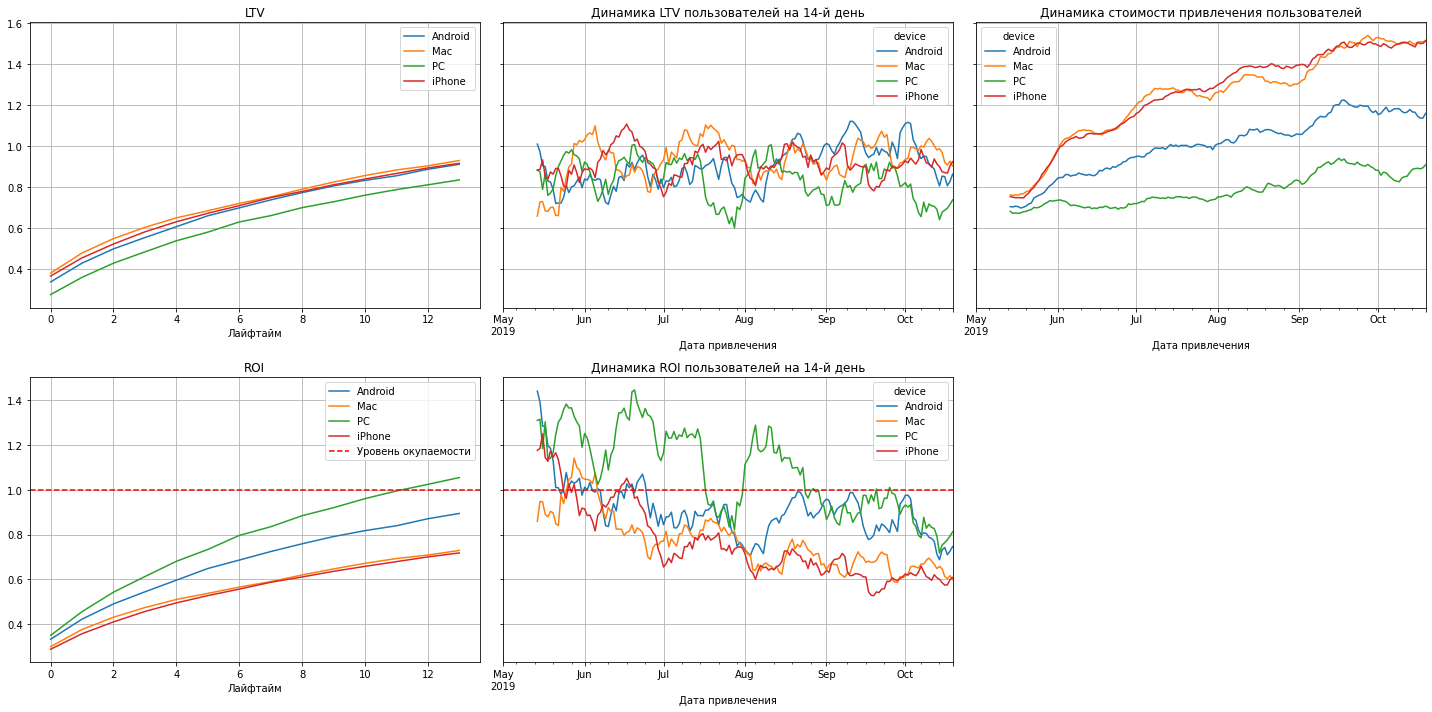

In [183]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Графики показывают, что несмотря на то, что устройства `Mac` и `iPhone` наиболее популярны среди платящих пользователей, расходы на них не окупаются. Динамика ROI для пользователей `Mac`, `iPhone` и `Android` резко снижается в начале рекламной кампании, уходя ниже порога окупаемости сразу в течение первого месяца.

Динамика ROI пользователей других устройств также снижается с течением времени. У пользователей `PC` кривая ROI снижается постепенно и с сентября не поднимается выше порога окупаемости.

Таким образом, поскольку общая динамика снижается, можно сделать вывод, что проблема не в устройстве.

### Окупаемость по странам

*Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.*

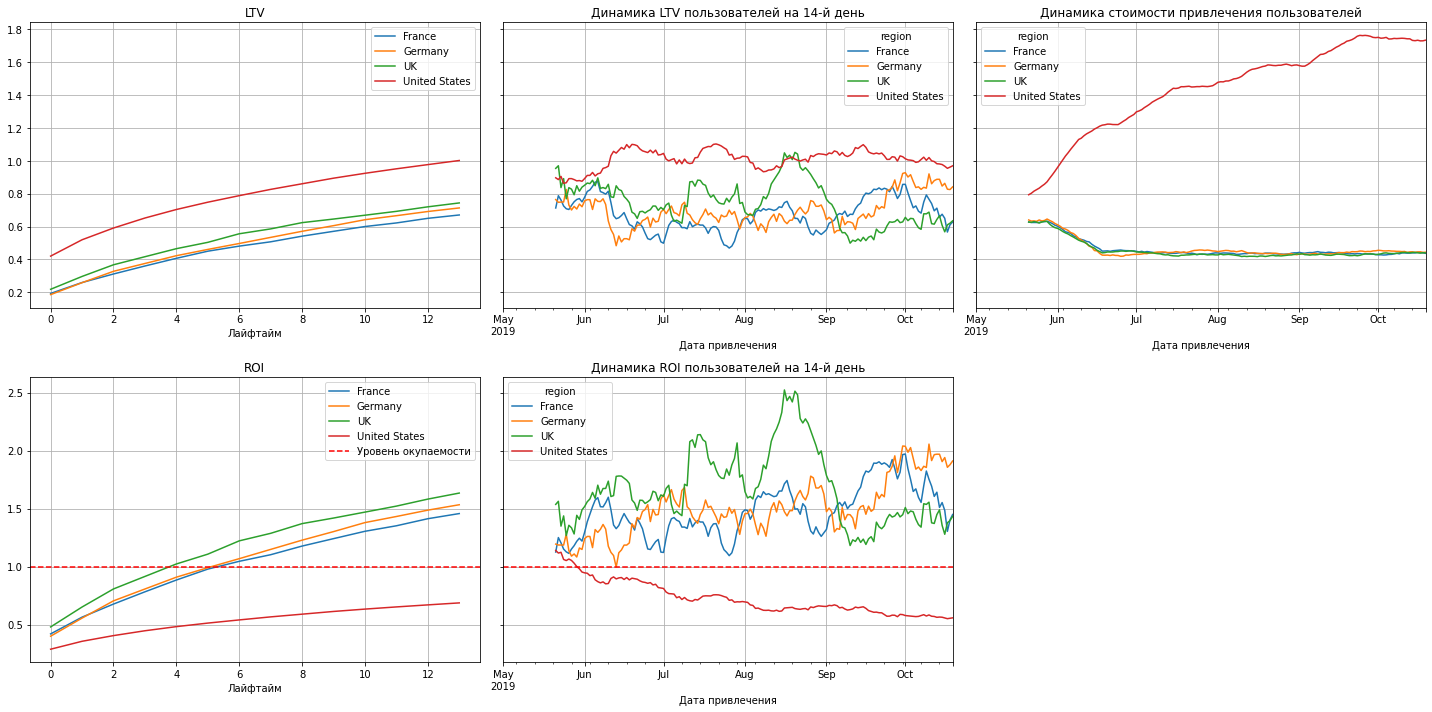

In [186]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=21
) 

Среди стран - самые плохие показатели у США. По сравнению с другими странами, LTV пользователей США выше LTV пользователей из других стран. 

Стоимость привлечения пользователей из США сильно растет, а окупаемость падает с самого начала рекламной кампании, в то время как в других странах стоимость привлечения на одном уровне, пользователи начинают окупаться на 4-6 день, а динамика окупаемости всегда положительная.

### Окупаемость по каналам

*Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.*

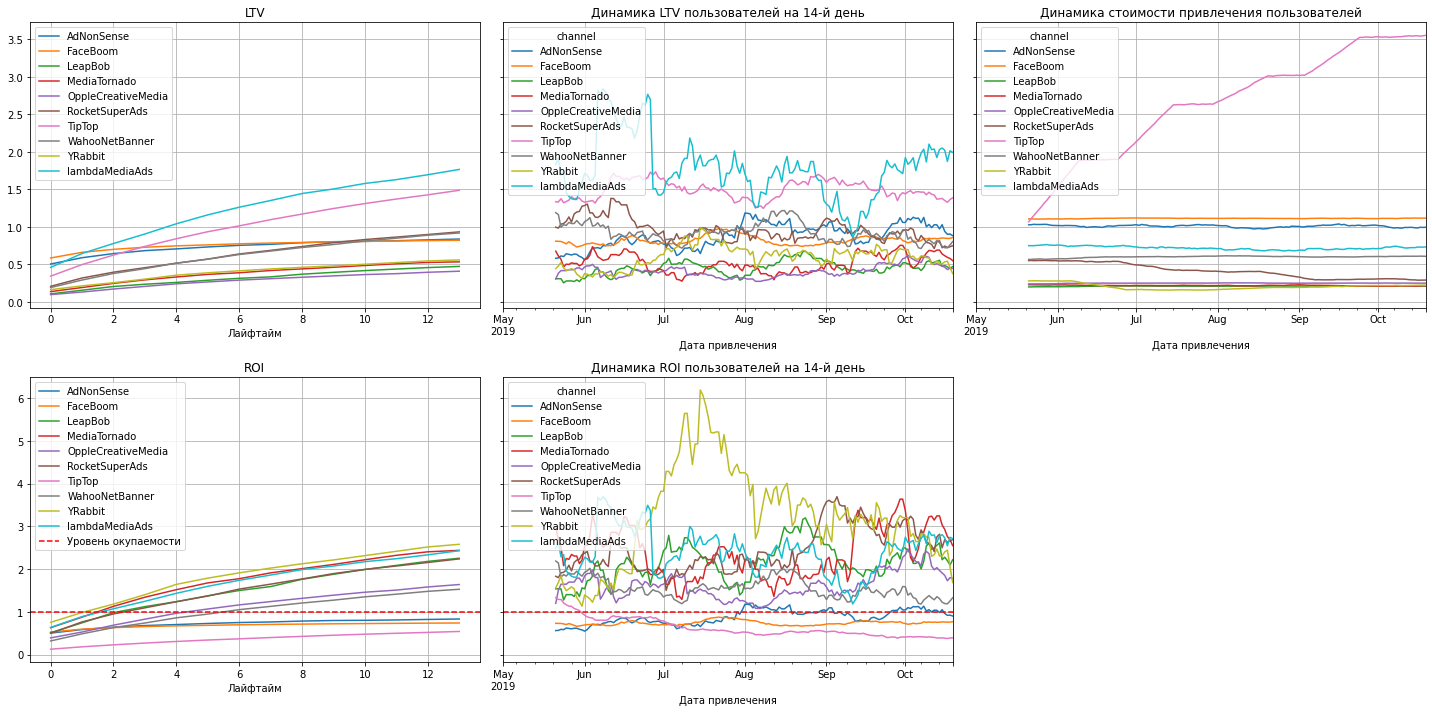

In [187]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=21
) 

Графики показывают, что в каналах `TipTop`, `FaceBoom` и `AdNonSense` реклама не окупается, в то время как у остальных каналов пересечение порога окупаемости происходит до пятого дня. Затраты на `TipTop` сильно превышают затраты на остальные каналы.

Хорошие показатели LTV имеют каналы `lambdaMediaAds` и `TipTop`.

### Удержание и конверсия по регионам

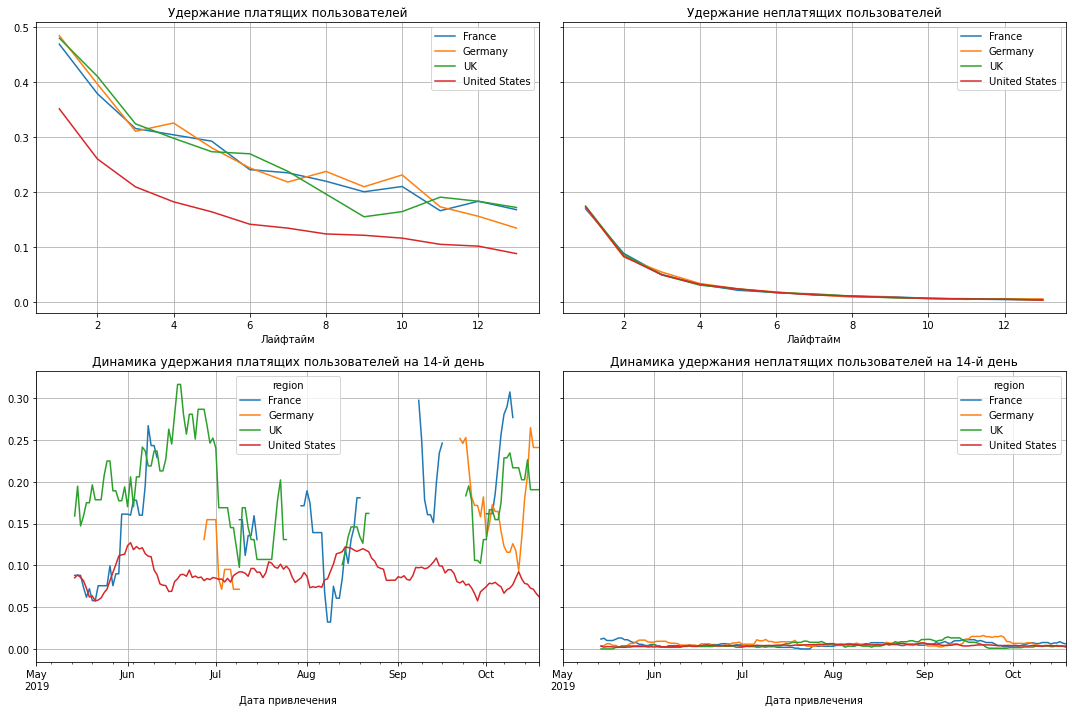

In [194]:
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days , window = 14)

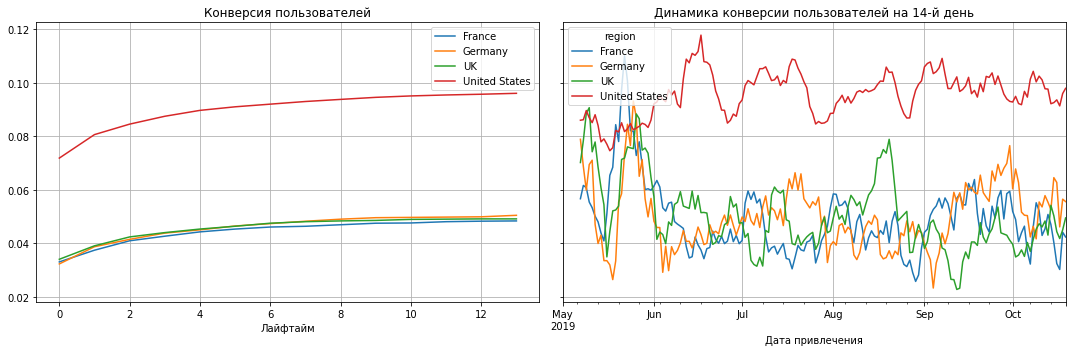

In [195]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Пользователи из США показывают хорошую конверсию по сравнению с остальными, но низкое удержание.

### Удержание и конверсия по каналам

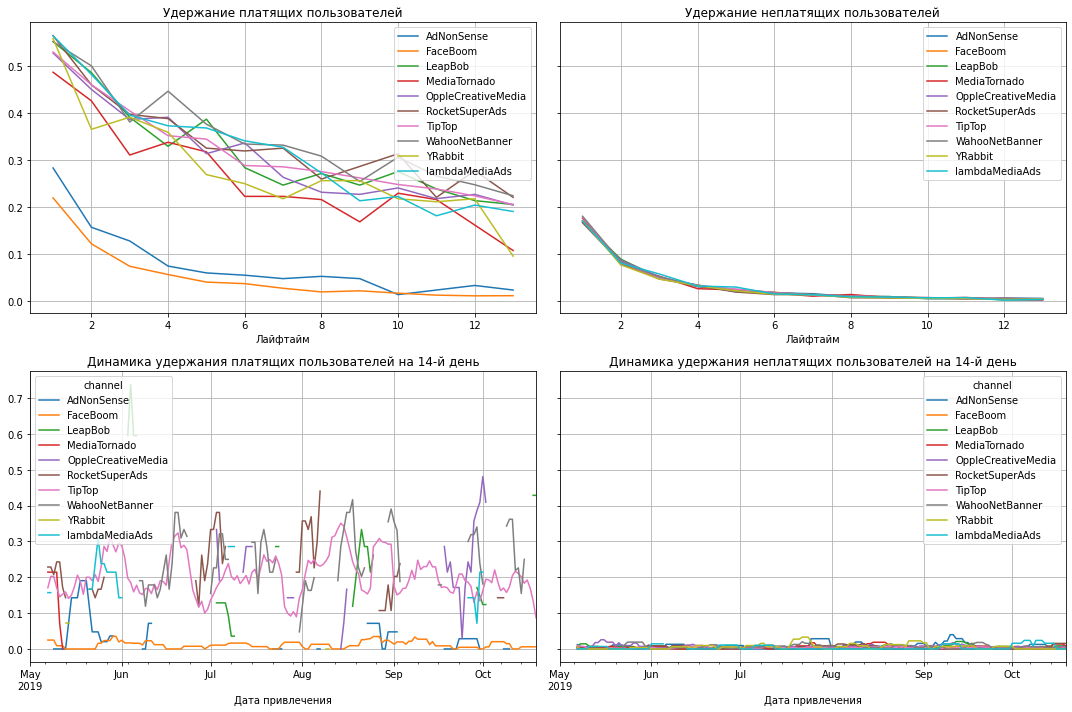

In [196]:
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

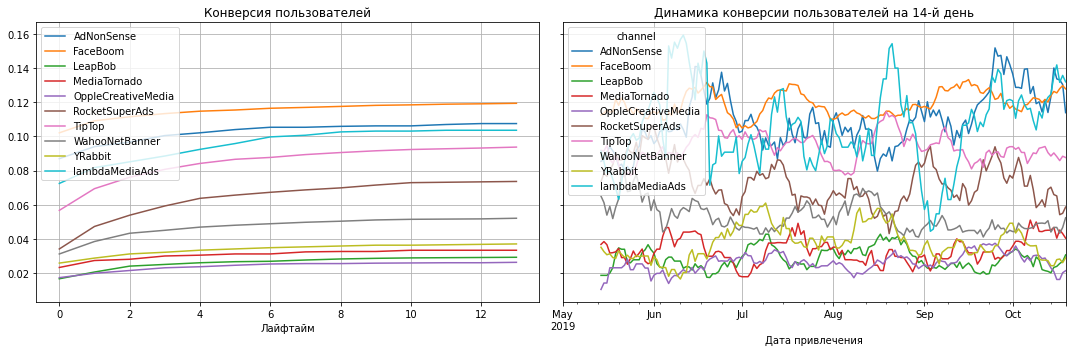

In [197]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window = 14)

Каналы `FaceBoom` и `AdNonSense` имеют самые высокие значения конверсии и в то же время показывают очень низкие значения удержания платящих пользователей.

### Итоги окупаемости

Реклама не окупается начиная с первых месяцев рекламной компании.

Исследование показало, что помимо всеобщего снижения динамики окупаемости, платформы `Mac`, `iPhone` и `Android` с течением времени окупаются все хуже и хуже. Падение динамики окупаемости характерно для всех платформ, так что причина падения окупаемости не в платформе.

Среди стран - самые плохие показатели у США. По сравнению с другими странами, LTV пользователей США выше LTV пользователей из других стран. 

Стоимость привлечения пользователей из США сильно растет, а окупаемость падает с самого начала рекламной кампании, в то время как в других странах стоимость привлечения на одном уровне, пользователи начинают окупаться на 4-6 день, а динамика окупаемости всегда положительная.

Среди рекламных каналов отрицательную окупаемость имеют каналы `TipTop`, `FaceBoom` и `AdNonSense`.

Проблемы окупаемости могут быть вызваны ошибками в распределении финансирования в рекламные каналы.

---

Как было выяснено ранее, часть каналов - `TipTop` и `FaceBoom` - получали очень большое финансирование (более 80%), что стало причиной снижения окупаемости - расходы на рекламу начали превышать прибыль.

In [198]:
channel_costs.sort_values(by = 'costs' , ascending = False).T.round(2)

channel,TipTop,FaceBoom,WahooNetBanner,AdNonSense,OppleCreativeMedia,RocketSuperAds,LeapBob,lambdaMediaAds,MediaTornado,YRabbit
costs,54751.3,32445.60,5151.00,3911.25,2151.25,1833.00,1797.6,1557.60,954.48,944.22
rate,51.9,30.75,4.88,3.71,2.04,1.74,1.7,1.48,0.90,0.90


Еще один не окупившийся канал - `AdNonSense` - получил около 4% от общего финансирования, имел высокую конверсию, но низкое удержание.

In [193]:
# посмотрим какие страны привлекают проблемные каналы
profiles.query(
    'channel == "TipTop" or channel == "FaceBoom" or channel == "AdNonSense"'
).groupby(["channel", "region"]).agg({"user_id": "nunique"})

user_id
channel    region                
AdNonSense France            1366
           Germany           1219
           UK                1295
FaceBoom   United States    29144
TipTop     United States    19561

Самые финансируемые каналы - `TipTop` и `FaceBoom` - расположены в Америке. Это объясняет отсутствие окупаемости в США. 

Таким образом, сначала необходимо урезать финансирование каналов `TipTop` и `FaceBoom` и вложить деньги в альтернативные американские каналы, например в  `YRabbit` или `MediaTornado`, у которых несмотря на низкие значения LTV, самые высокие значения ROI. В отношении Европы можно рассмотреть канал `lambdaMediaAds`, так как у этого канала высокие значения конверсии и динамики LTV.

## Выводы

Основными причинами неэффективности привлечения клиентов было сосредоточение большей части инвестиций (80%) на двух рекламных каналах - `TipTop` и `FaceBoom` - на протяжении всего рассматриваемого периода и игнорирование остальных каналов. Вложение большого количества средств привело множество покупателей, но в итоге цена этих покупателей стала слишком высока , что привело к снижению окупаемости в США.

Решением проблемы стало бы урезание финансирования каналов `TipTop` и `FaceBoom` и вложение средств в альтернативные американские каналы, например в  `YRabbit` или `MediaTornado`, у которых несмотря на низкие значения LTV, самые высокие значения ROI. Также можно рассмотреть `RocketSuperAds` - канал обладает неплохими значенями конверсии.

В отношении Европы окупаемость на хорошем уровне, но также можно было бы рассмотреть финансирование канала `lambdaMediaAds`, так как он обладает высокими значениями динамики LTV и конверсии пользователей.